In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

## 1.1 Compute ROC & AUC for combined test sets. n=10, r=4

In [55]:
def convert_txt_to_array(filepath):
    return np.array(open(filepath, 'r').readlines()).astype('float32')

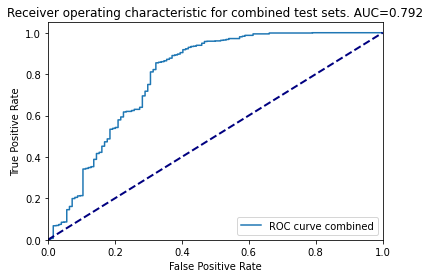

In [56]:
## Load in prediction files
english_preds = convert_txt_to_array('english_testpred_r4.txt')
tagalan_preds = convert_txt_to_array('tagalog_testpred_r4.txt')
combined_preds = convert_txt_to_array('combined_testpred_r4.txt')
preds = [english_preds, tagalan_preds, combined_preds]
names = ['english', 'tagalan', 'combined']

## determine class labels
n_english, n_tagalan, n_combined = english_preds.shape[0], tagalan_preds.shape[0], combined_preds.shape[0]
english_labels = np.zeros(n_english)
tagalan_labels = np.ones(n_tagalan)
combined_labels = np.ones(n_combined)
combined_labels[:n_english] = 0.
labels = [english_labels, tagalan_labels, combined_labels]

## fit roc curve on combined labels
plt.figure()   
fpr, tpr, _ = roc_curve(y_true=combined_labels, y_score=combined_preds)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve '+names[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic for combined test sets. AUC={np.round(auc_score,3)}')
plt.legend(loc="lower right")
plt.savefig('figures/1a_roc_curve.png')
plt.show()



## 1.2 : varying the value of r

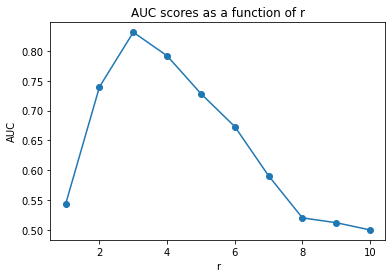

In [57]:
r_values = np.arange(1,11) 
auc_scores = np.zeros(len(r_values))
for i,r in enumerate(r_values):
    filepath = f'r_values/r{r}_preds.txt'
    preds = convert_txt_to_array(filepath)
    fpr, tpr, _ = roc_curve(y_true=combined_labels, y_score=preds)
    auc_scores[i] = auc(fpr, tpr)
    
## Plot auc scores as a function of r
plt.figure()
plt.plot(r_values, auc_scores)
plt.scatter(r_values, auc_scores)
plt.xlabel('r')
plt.ylabel('AUC')
plt.title('AUC scores as a function of r')
plt.savefig('figures/1b_auc_scores.png')
plt.show()    

## 1.3 Diffferent languages

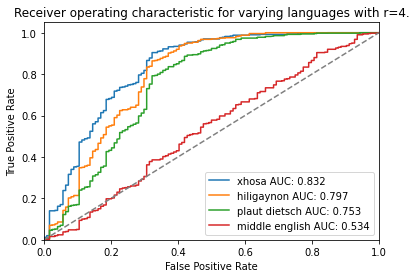

In [58]:
## load in predictions
hiligaynon = 'lang/english_hiligaynon_r4_preds.txt'
middle_english = 'lang/english_middle-english_r4_preds.txt'
plautdietsch = 'lang/english_plautdietsch_r4_preds.txt'
xhosa = 'lang/english_xhosa_r4_preds.txt'
paths = [xhosa, hiligaynon, plautdietsch, middle_english]
names = [ 'xhosa', 'hiligaynon'  , 'plaut dietsch', 'middle english']

## iterate over languages
FPR, TPR, AUC = [], [], np.zeros(len(paths))
for i, path in enumerate(paths):
    pred = convert_txt_to_array(path)
    labels = np.ones(len(pred))
    labels[:n_english] = 0.

    # save fpr, tpr
    fpr, tpr, _ = roc_curve(y_true=labels, y_score=pred)
    AUC[i] = auc(fpr, tpr)
    FPR.append(fpr)
    TPR.append(tpr)
    
    
## plot ROC curves
plt.figure()  
for i, (fpr, tpr) in enumerate(zip(FPR,TPR)):
    plt.plot(fpr, tpr, label=f'{names[i]} AUC: {np.round(AUC[i],3)}')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic for varying languages with r=4.')
plt.legend(loc="lower right")
plt.savefig('figures/1c1_roc_curves.png')
plt.show()

## Plot AUC values as bar plot


## Question 2: dataset 1 - snd-cert folder

In [ ]:
import os
import pandas as pd
r_values = np.arange(1,8)


# Some naming functions
cert = 'syscalls/snd-cert'
train_fixed = f'{cert}/snd-cert.trainfixed'
test_set = lambda i: f'{cert}/snd-cert.{i}.test'
label = lambda i: f'{cert}/snd-cert.{i}.labels'
pred = lambda i: f'{cert}/snd-cert.{i}.preds.txt'

## fix data of training set
k = 7 # string length
sndcert_train = [[line[i:i+k] for i in range(len(line)-(k+1))] for line in open(f'{cert}/snd-cert.train')]
sndcert_train = [i for j in sndcert_train for i in j]

# save new training format
f = open(train_fixed, 'w')
f.writelines("\n".join(sndcert_train))
f.close()
print('Wrote training file')

n_test_sets = 3
for i in range(1,n_test_sets+1):

    cert_test,cert_labels,cert_ids = [],[],[]

    # Read in labels of each unchunked line
    labels = np.array(open(label(i), 'r').readlines())

    # read in test data, save chunked strings
    for j, line in enumerate(open(test_set(i),'r')):
        string = line
        while len(string)>k:
            cert_test.append(string[:k])
            string = string[1:]
            cert_labels.append(labels[j])
            cert_ids.append(j)
    cert_labels = np.array(cert_labels)        
    cert_test = np.array(cert_test)
    cert_ids = np.array(cert_ids)

    assert cert_labels.shape == cert_test.shape

    # write results back to txt files
    f = open(f'{test_set(i)}fixed','w')
    f.writelines("\n".join(cert_test))
    f.close()

    f = open(f'{label(i)}labels','w')
    f.writelines("\n".join(cert_labels))
    f.close()
    
    # Do analysis on files
    certs = np.stack((cert_ids,cert_labels.astype('float32')),1)
    df = pd.DataFrame(data=certs, columns=["ID","label"], dtype=float)
    for r in r_values:
        print(f'now computing for r={r}',end='\r')
        os.system(f'java -jar negsel2.jar -self {train_fixed} -n 7 -r {str(r)} -c -l < {test_set(i)}fixed > {pred(i)}')
        scores = convert_txt_to_array(pred(i))
        df[f'score_r{r}'] = scores

    grouped=df.groupby('ID').agg('avg')
    grouped.to_csv(f'{test_set(i)}_scores_Dataframe')



Wrote training file
now computing for r=1
now computing for r=2
now computing for r=3
now computing for r=4
now computing for r=5


In [112]:
AUC = np.zeros((n_test_sets,len(r_values)))
for j in range(1,n_test_sets+1):
    
    data = pd.read_csv(f'{test_set(j)}_scores_Dataframe')[2:]
    labels = data["label"].to_numpy().astype("float32").astype("int16")
    
    for r in r_values:
        preds = data[f"score_r{r}"].to_numpy().astype("float32")
        fpr, tpr, _ = roc_curve(y_true=labels, y_score=preds)
        AUC[j-1,r-1] = auc(fpr, tpr)


[0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1
 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0
 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0

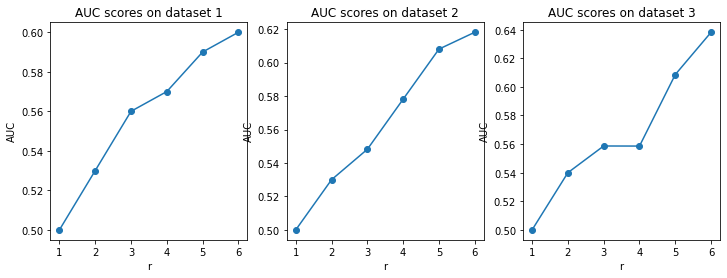

In [114]:
## Plot AUC vs r values
fig2, ax2 = plt.subplots(1,3,figsize=(12,4))
ax2 = ax2.ravel()
for n in range(3):
    ax2[n].plot(r_values, AUC[:,n])
    ax2[n].scatter(r_values, AUC[:,n])
    ax2[n].set_xlabel('r')
    ax2[n].set_ylabel('AUC')
    ax2[n].set_title(f'AUC scores on dataset {n+1}')
plt.savefig('figures/1b_auc_scores.png')
plt.show()    

## dataset 2 - snd-unm 

In [ ]:
import os
import pandas as pd
r=4
r_values = np.arange(1,6)
AUC_scores = []

#topdir = "/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/asgn/asgn3/unzipped/negative-selection"
for r in r_values:

    ## fix data of training set
    sndcert_train = []
    k = 7 # string length
    for line in open(topdir+'syscalls/snd-unm/snd-unm.train', 'r'):
        # iterate over all lines
        string = line
        if len(string) >= k:
            # add bits of length n to array
            sndcert_train.append(string[:k])
            string = string[1:]
    sndcert_train = np.array(sndcert_train)

    # save new training format
    with open(topdir+'syscalls/snd-unm/snd-unm.trainfixed', 'w') as output_file:
        for i in range(len(sndcert_train)):
            output_file.write(sndcert_train[i]+'\n')

    print('done with writing training file')

    ## fix data of test sets and labels
    test_sets = ['snd-unm/snd-unm.1.test', 'snd-unm/snd-unm.2.test', 'snd-unm/snd-unm.3.test']
    labels = ['snd-unm/snd-unm.1.labels', 'snd-unm/snd-unm.2.labels', 'snd-unm/snd-unm.3.labels']        
    
    FPR, TPR, AUC = [], [], np.zeros((len(r_values)))

    for i, (test_set, label) in enumerate(zip(test_sets, labels)):

        cert_test= []
        cert_labels = []
        cert_ids = []
        # Read in labels of each unchunked line
        labels = []
        for line in open(topdir+'syscalls/'+label, 'r'):
            labels.append(line)
        labels = np.array(np.float32(labels))

        # read in test data, save chunked strings
        for j, line in enumerate(open(topdir+'syscalls/'+test_set,'r')):
            string = line
            while len(string)>=k+1:
                cert_test.append(string[:k])
                string = string[1:]
                cert_labels.append(labels[j])
                cert_ids.append(j)

        cert_labels = np.array(cert_labels)        
        cert_test = np.array(cert_test)
        cert_ids = np.array(cert_ids)

        assert cert_labels.shape == cert_test.shape


        ## write results back to txt files
        with open(topdir+'syscalls/'+test_set+'fixed', 'w') as output_file:
            for j in range(len(cert_test)):
                output_file.write(cert_test[j]+'\n')
        with open(topdir+'syscalls/'+label+'fixed', 'w') as output_file:
            for j in range(len(cert_test)):
                output_file.write(str(cert_labels[j])+'\n')  
        print(r)
        store_path = f'{topdir}syscalls/snd-unm/test{i+1}preds.txt'
        os.system(f'java -jar negsel2.jar -self {topdir}syscalls/snd-unm/snd-unm.trainfixed -n 7 -r {str(r)} -c -l < {topdir}syscalls/{test_set}fixed > {store_path}')
        scores = convert_txt_to_array(store_path)
        certs = np.stack((cert_ids,cert_labels.astype('float32'),scores),1)
        df = pd.DataFrame(data=certs, columns = ["ID","label","score"], dtype=float)

        grouped=df.groupby('ID').agg({'label':['max'],'score':['mean']})
        grouped.to_csv(f'{topdir}syscalls/{test_set}_scores_Dataframe')

        names = np.array(['test 1', 'test 2', 'test3'])
        for i in range(len(test_sets)):
            data = pd.read_csv(f'{topdir}syscalls/{test_set}_scores_Dataframe')
            data = data[2:] 
            labels = data["label"].to_numpy().astype("float32").astype("int16")
            preds = data["score"].to_numpy().astype("float32")

            fpr, tpr, _ = roc_curve(y_true=labels, y_score=preds)
            AUC[i] = auc(fpr, tpr)
            FPR.append(fpr)
            TPR.append(tpr)
    AUC_scores.append(AUC)



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

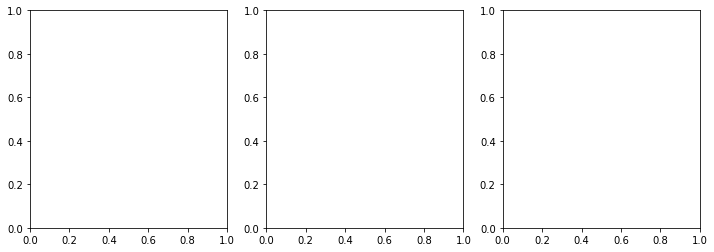

In [44]:
## Plot AUC vs r values
fig2, ax2 = plt.subplots(1,3,figsize=(12,4))
ax2 = ax2.ravel()
scores = np.array(AUC_scores)
scores = scores[:,:3]
for n in range(3):
    ax2[n].plot(r_values, scores[:,n])
    ax2[n].scatter(r_values, scores[:,n])
    ax2[n].set_xlabel('r')
    ax2[n].set_ylabel('AUC')
    ax2[n].set_title('AUC scores as a function of r')
plt.savefig('figures/1b_auc_scores_unm.png')
plt.show()    